# Przetwarzanie raportów resuscytacyjnych za pomocą OpenAI API

## Wstęp 
Celem niniejszej pracy jest zaprojektowanie i implementacja systemu przetwarzania szpitalnych raportów resuscytacyjnych. 

Praca skupi się na opracowaniu programu umożliwiającego efektowną i dokładną analizę przebiegu wielu interwencji naraz oraz wyciągnięciu wniosków, które mogą poprawić procedury medyczne. 

### Import danych
W pierwszej części dane w postaci pliku JSON zostają zaimportowane.

In [2]:
import json
import os

def import_data(filepath): 
  """
  Imports data from a JSON file and converts it to a string format.

  Parameters:
  filepath (str): Path to the JSON file.

  Returns:
  str: Data from the JSON file as a single string with elements separated by newlines.

  Raises:
  FileNotFoundError: If the file does not exist.
  ValueError: If the file content is not a valid JSON.
  TypeError: If the JSON content is not a list of strings.
  """
  if not os.path.exists(filepath):
      raise FileNotFoundError(f"The file '{filepath}' does not exist.")
  
  try:
      with open(filepath, 'r') as file:
          data = json.load(file)
      if not isinstance(data, list) or not all(isinstance(item, str) for item in data):
          raise TypeError("The JSON content must be a list of strings.")
      return "\n".join(data)
  
  except json.JSONDecodeError as e:
      raise ValueError(f"Failed to decode JSON: {e}")

### Podział raportów na paczki
W tej sekcji raporty zostają podzielone na paczki (batches), tak, aby zoptymalizować liczbę tokenów wysyłanych do modelu. 

Token to najmniejsza jednostka tekstu przetwarzana przez model językowy, taka jak słowo, część słowa, znak interpunkcyjny lub spacja. W przypadku uzywanego tutaj modelu GPT-4-turbo maksymalna liczba tokenów wynosi 4096, stąd zapytanie razem z raportami musi mieścić się w tym zakresie.

Instrukcja wysyłana jest do modelu razem z kolejnymi paczkami az do momentu wyczerpania paczek. 

In [40]:
import tiktoken

def split_reports_into_batches(report_list, prompt, max_tokens=4096):
    """
    Splits a list of reports into batches based on token limits, ensuring that the total token count
    (including a given prompt) does not exceed the specified maximum tokens per batch.

    Parameters:
        report_list (list of str): A list of report strings to be split into batches.
        prompt (str): The prompt text to include with each batch, which affects the token limit.
        max_tokens (int, optional): The maximum number of tokens allowed in a single batch, including the prompt, defaults to 4096.

    Returns:
        list of list of str: A list of batches, where each batch is a list of reports whose combined token count 
        (plus the prompt) stays within the maximum token limit.
    """
    tokenizer = tiktoken.get_encoding("cl100k_base")
    
    prompt_tokens = len(tokenizer.encode(prompt))
    max_tokens_per_batch = max_tokens - prompt_tokens

    batches = []
    current_batch = []
    current_tokens = 0

    for report in report_list:
        report_tokens = tokenizer.encode(report)
        report_token_count = len(report_tokens)

        if current_tokens + report_token_count > max_tokens_per_batch:
            batches.append(current_batch)
            current_batch = []
            current_tokens = 0

        current_batch.append(report)
        current_tokens += report_token_count

    if current_batch:
        batches.append(current_batch)

    return batches

### Połączenie z modelem 
Zachodzi domyślnie dla modelu GPT-4-turbo.

In [4]:
from openai import OpenAI

def get_response(prompt):
    """
    Sends a prompt to an external chat model (gpt-4-turbo) and retrieves the response.

    Parameters:
    prompt (str): The input string to be processed by the model.

    Returns:
    str: The response generated by the model.

    Raises:
    ValueError: If the prompt is empty or invalid.
    Exception: For any unexpected errors during the API call.
    """
    try:
        if not isinstance(prompt, str) or not prompt.strip():
            raise ValueError("Prompt must be a non-empty string.")
        
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            temperature=0.0,
            messages=[
                {"role": "system", "content": "Jesteś pomocnym asystentem."},
                {"role": "user", "content": prompt}
            ],
        )
        
        assistant_response = response.choices[0].message.content
        
        if not assistant_response or not isinstance(assistant_response, str):
            raise ValueError("Model response is empty or invalid.")
        
        return assistant_response.strip()

    except ValueError as ve:
        print(f"Input or response validation error: {ve}")
        raise  
        
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise 

## Przetwarzanie danych

### Prompt i przetwarzanie odpowiedzi modelu
Prompt wysyłany do modelu ma dwie funkcje. 

1. Oddzielenie raportów resuscytacyjnych od raportów jedyne wspominających o poprzedniej resucytacji (w tej sytuacji model ma zwrócić łańcuch znaków 'BRAK'). 

2. Zwrócenie przez model odpowiedzi na raport resuscytacyjny w postaci oddzielonych od siebie przecinkiem słów kluczowych (takich jak asystolia, ambu, defibrylacja, ROSC), które mają informować w jak najbardziej skróconej i gotowej do przetworzenia formie o procedurach, jakie miały miejsce podczas resuscytacji. 

Treść wszystkich raportów jest wysoce róznorodna i pojawiają się w nich takze informacje o np. problemach związanych z intubacją, chorobach współtowarzyszących pacjenta lub kilkukrotnych defibrylacjach podczas jednej resuscytacji. W promptcie skupiono się jednak na najczęściej powtarzanych procedurach, ograniczając "słownik" odpowiedzi modelu do konkretnych pojęć. 

#### Metody prompt engineering 

W powyzszej instrukcji wykorzystano następujące metody prompt engineering: 

1. **Role instruction**
("Jesteś specjalistą od analizy danych medycznych"): Pomaga skoncentrować działanie modelu na odpowiedniej dziedzinie i nadaje kontekst.

2. **Explicit instructions**
Szczegółowo opisano zadanie podziału raportów na dwie kategorie i podano wytyczne, jak postępować w przypadku kazdej z kategorii. 

3. **Constrained output**
Zdefiniowano słownik pojęć, aby zredukować ryzyko uzycia nieodpowiednich terminów. 

4. **Few-Shot Learning**
Dołączono przykłady raportów i ich odpowiedzi. 

5. **Standardized Output** 
Wymóg utrzymania standardowego formatu odpowiedzi w mianowniku (np. “czas X”, “adrenalina”).

6. **Disambiguation** 
Rozwiązano potencjalne niejasności poprzez wyjaśnienie wyjątków (np. bradyasystolia → asystolia) oraz oczekiwana reakcja na brak danych (“BRAK”) została zdefiniowana jednoznacznie.

7. **Task Prioritization**
Zadanie jest podzielone na dwa logiczne kroki:
	1.	Przyporządkowanie raportu do kategorii.
	2.	Generowanie odpowiedzi w formie słów kluczowych lub zwrócenie “BRAK”.
	

8. **Highlighting Key Points**
Uzycie pogrubienia ("**Kategoria 1**") i dodatkowych tagów (<\raporty>) ułatwiające modelowi priorytetyzację.

In [4]:
prompt_summarize = """
Jesteś specjalistą od analizy danych medycznych. Przeczytaj podane raporty (konsultacje) szpitalne i przyporządkuj kazdy do jednej z dwóch kategorii:
1. **Kategoria 1**: Konsultacja opisuje aktywną resuscytację pacjenta, obejmującą działania takie jak: podjęcie resuscytacji, intubacja, podanie leków ratunkowych (np. adrenaliny), użycie defibrylatora, wykonywanie masażu serca itp.
2. **Kategoria 2**: Konsultacja odnosi się do wcześniejszej resuscytacji, ale nie opisuje aktywnej resuscytacji w trakcie danej konsultacji (np. stan pacjenta po wcześniejszym NZK, informacje o przebytej resuscytacji bez szczegółów interwencji w obecnym czasie).

Twoje zadanie:
1. Jeśli raport należy do **Kategorii 1**, zamień raport na zestawienie w formie słów kluczowych. Słowa kluczowe mają być zapisane w mianowniku i w pełni standaryzowane. Oto słowa kluczowe, z których masz korzystać w odpowiedzi i z niczego innego:
   - **Mechanizmy**: "asystolia" (bradyasystolię tez traktuj jako asystolię), "VF" (migotanie komór), "PEA" (aktywność elektryczna bez tętna).
   - **Czas**: czas trwania resuscytacji w minutach, określony jako różnica czasu zakończenia resuscytacji i jej rozpoczęcia lub wystąpienia NZK ("czas X"). Jeśli brak informacji, pomiń parametr czasu.
   - **Procedury**: "intubacja", "lucas", "ambu", "masaż serca", "defibrylacja", podane leki: "adrenalina", "bikarbonat", "amiodaron", "inne leki".
   - **Wynik**: "ROSC", "zgon".

   Jeśli w raporcie brakuje danych, pomiń te parametry w odpowiedzi. Zachowaj standardowy format wyjściowy.

2. Jeśli raport należy do **Kategorii 2**, zwróć dokładnie tekst: 'BRAK'.

### Przykłady
**Raporty:**  
["Wezwanie na interwencję z powodu nagłego zatrzymania krążenia (NZK). Według relacji personelu SOR, zatrzymanie krążenia nastąpiło około godziny 14:30 w mechanizmie asystolii. Natychmiast rozpoczęto RK, wykonując masaż zewnętrzny serca oraz intubując pacjenta przez usta. Rozpoczęto wentylację przy pomocy worka Ambu, a masaż serca kontynuowano przy użyciu urządzenia Lucas.
W trakcie działań podano łącznie 6 mg adrenaliny. Pomimo przeprowadzonych działań resuscytacyjnych, nie uzyskano ROSC. O godzinie 15:00 stwierdzono zgon pacjenta.", "Przy przybyciu pacjent był masowany oraz wentylowany za pomocą worka Ambu. Pacjenta zaintubowano przez usta rurką 8.5. Podawano adrenalinę zgodnie z aktualnymi wytycznymi. Pomimo prowadzonej akcji resuscytacyjnej nie uzyskano ROSC. O godzinie 16:10 stwierdzono zgon chorego.", "Pacjent NN o nieznanej przeszłości chorobowej, zaniedbany higienicznie. Stan po NZK i skutecznej resuscytacji wykonanej przez ZRM. Obecnie pacjent w stanie śpiączki, wentylowany mechanicznie, hemodynamicznie stabilny na wlewie noradrenaliny. W wykonanym TK głowy wykluczono krwawienie. Zalecenia: pełne monitorowanie, kontrolne badania laboratoryjne, RTG klatki piersiowej, ewentualna decyzja o koronarografii po ocenie stanu neurologicznego."]
**Odpowiedź:**  
["asystolia, masaż serca, intubacja, ambu, lucas, adrenalina, czas 30, zgon", "masaż serca, intubacja, ambu, adrenalina, zgon", "BRAK"]
""" 

def summarize_batches(batches):
    """
    Processes batches of medical reports and combines their summarized results.

    Parameters:
    batches (list of list of str): A list of batches, where each batch is a list of medical reports.

    Returns:
    list of str: Combined list of summarized reports without leading numbers or extra quotes.
    """
    combined_summaries = []

    for batch in batches:
        try:
            batch_content = "\n\n".join(batch)
            final_prompt = prompt_summarize + f"\n\n<raporty>\n{batch_content}\n</raporty>"
            
            response = get_response(final_prompt)
            
            summaries = [item.strip() for item in response.split("\n") if item.strip()]
            
            clean_summaries = []
            for summary in summaries:
                clean_summary = summary.split(".", 1)[-1].strip()
                clean_summary = clean_summary.strip('"')
                clean_summaries.append(clean_summary)
            
            combined_summaries.extend(clean_summaries)
        
        except Exception as e:
            print(f"Error processing batch: {batch}\nError: {e}")

    return combined_summaries

### Import danych do biblioteki pandas i ich przetwarzanie

In [47]:
import pandas as pd
import ast 

# Wcześniej zapisana odpowiedź modelu w pliku 'summ_data.txt'. Plik odczytano i przekonwertowano na listę
with open('summ_data.txt', 'r', encoding='UTF-8') as file:
    data_as_string = file.read() 

data_list = ast.literal_eval(data_as_string)
data_list[0:5]

['asystolia, masaż serca, intubacja, ambu, lucas, adrenalina, czas 30, zgon',
 'BRAK',
 'asystolia, masaż serca, intubacja, ambu, adrenalina, zgon',
 'VF, masaż serca, intubacja, adrenalina, amiodaron, defibrylacja, inne leki, ROSC',
 'asystolia, masaż serca, intubacja, ambu, adrenalina, zgon']

In [48]:
df = pd.DataFrame(data_list, columns=["report"])
df                

,report
0,"asystolia, masaż serca, intubacja, ambu, lucas..."
1,BRAK
2,"asystolia, masaż serca, intubacja, ambu, adren..."
3,"VF, masaż serca, intubacja, adrenalina, amioda..."
4,"asystolia, masaż serca, intubacja, ambu, adren..."
...,...
331,"PEA, masaż serca, intubacja, lucas, adrenalina..."
332,"masaż serca, intubacja, ambu, lucas, adrenalin..."
333,"masaż serca, intubacja, adrenalina, zgon"
334,"asystolia, masaż serca, adrenalina, czas 20, zgon"


In [50]:
# Pozbycie się konsultacji wspominających o przeszłej resuscytacji ('BRAK')
df = df[df['report'] != 'BRAK']
rep_list_len = len(df)

df.reset_index(drop=True, inplace=True)

def process_report(report):
    """
    Processes a single medical report to extract key components.

    This function identifies and categorizes elements from a medical report string into 
    the following categories:
    - Mechanisms (e.g., "asystolia", "VF", "PEA")
    - Procedures (e.g., "intubacja", "lucas", "ambu", etc.)
    - Results (e.g., "ROSC", "zgon")
    - Time (e.g., "czas X", including ranges like "czas 20-30", where the average is calculated)

    Parameters:
        report (str): The input report string containing comma-separated elements.

    Returns:
        dict: A dictionary containing the following keys:
            - "mechanisms": A sorted list of mechanisms present in the report, or None if absent.
            - "procedures": A sorted list of procedures identified in the report.
            - "result": A sorted list of results (e.g., "ROSC", "zgon"), or None if absent.
            - "time": The extracted time as a numeric value (or average for ranges), or None if unavailable.
    """
    # Kategorie
    mechanisms = {"asystolia", "VF", "PEA"}
    procedures = {"intubacja", "lucas", "ambu", "masaż serca", "defibrylacja",
                  "adrenalina", "bikarbonat", "amiodaron", "inne leki"}
    results = {"ROSC", "zgon"}
    
    # Parsowanie raportu
    elements = set(report.split(", "))
    mech = sorted(list(elements & mechanisms))  # Posegregowane mechanizmy
    proc = sorted(list(elements & procedures))  # Wszystkie procedury
    result = sorted(list(elements & results))  # Wynik 
    
    # Znalezienie czasu
    time = [el for el in elements if el.startswith("czas")]
    
    # Obsługa czasu
    extracted_time = None
    if time:
        try:
            time_value = time[0].split()[1]
            if "-" in time_value:  # Obsługa zakresów czasu (np. "czas 20-30")
                lower, upper = map(int, time_value.split("-"))
                extracted_time = (lower + upper) / 2  # Średnia z zakresu
            else:
                extracted_time = int(time_value)  
        except ValueError:
            extracted_time = None  # Jeśli nie jest liczbą ("czas X"), ustaw na None
    
    return {
        "mechanisms": mech if mech else None,  
        "procedures": proc,                    
        "result": result if result else None,  
        "time": extracted_time               
    }

processed_data = df["report"].apply(process_report)

df_processed = pd.DataFrame(processed_data.tolist())
df_processed

,mechanisms,procedures,result,time
0,[asystolia],"[adrenalina, ambu, intubacja, lucas, masaż serca]",[zgon],30.0
1,[asystolia],"[adrenalina, ambu, intubacja, masaż serca]",[zgon],NaN
2,[VF],"[adrenalina, amiodaron, defibrylacja, inne lek...",[ROSC],NaN
3,[asystolia],"[adrenalina, ambu, intubacja, masaż serca]",[zgon],NaN
4,[asystolia],"[adrenalina, bikarbonat, inne leki, intubacja,...",[ROSC],8.0
...,...,...,...,...
266,[asystolia],[intubacja],[zgon],NaN
267,[PEA],"[adrenalina, intubacja, lucas, masaż serca]",[zgon],NaN
268,None,"[adrenalina, ambu, intubacja, lucas, masaż serca]",[ROSC],10.0
269,None,"[adrenalina, intubacja, masaż serca]",[zgon],NaN


#### Mechanizmy
Informacje ekstrahowane z  mechanizmów NZK (asystolia, VF, PEA) to:
1. **Liczba wystąpień** każdego mechanizmu.
2. **Częstość współwystępowanima** mechanizmów w jednym raporcie.
3. **Proporcja** każdego mechanizmu względem całości raportów.

Liczba wystąpień mechanizmów wystąpienia NZK:
   mechanism  count
0  asystolia    173
1         VF     44
2        PEA     95

Liczba wystąpień mechanizmów współistniejących:
      co_occurrence  count
0   (VF, asystolia)     20
1         (PEA, VF)      8
2  (PEA, asystolia)     30

Proporcje wystąpień mechanizmów NZK:
   mechanism  proportion
0  asystolia    0.638376
1         VF    0.162362
2        PEA    0.350554


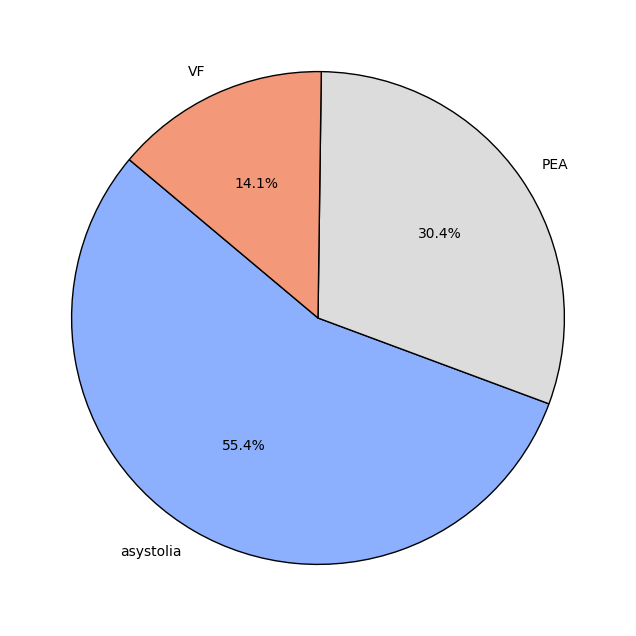

In [57]:
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Zamiana wartości NaN na puste listy w celu łatwiejszego przetwarzania
df.loc[:, "mechanisms"] = df_processed["mechanisms"].apply(lambda x: x if isinstance(x, list) else [])

# 1. Liczba wystąpień kazdego mechanizmu
mechanism_counts = Counter([mech for mechs in df["mechanisms"] for mech in mechs])

# 2. Częstość współwystępowania mechanizmów w jednym raporcie
co_occurrence_counts = Counter()
for mechs in df["mechanisms"]:
    co_occurrence_counts.update(combinations(sorted(mechs), 2))

# 3. Proporcja kazdego mechanizmu względem całości raportów
total_reports = len(df)
mechanism_proportions = {key: count / total_reports for key, count in mechanism_counts.items()}

mechanism_counts_df = pd.DataFrame.from_dict(mechanism_counts, orient="index", columns=["count"])
co_occurrence_counts_df = pd.DataFrame.from_dict(co_occurrence_counts, orient="index", columns=["count"])
mechanism_proportions_df = pd.DataFrame.from_dict(mechanism_proportions, orient="index", columns=["proportion"])

# Reset indeksu dla czytelności 
mechanism_counts_df.reset_index(inplace=True)
mechanism_counts_df.rename(columns={"index": "mechanism"}, inplace=True)

co_occurrence_counts_df.reset_index(inplace=True)
co_occurrence_counts_df.rename(columns={"index": "co_occurrence"}, inplace=True)

mechanism_proportions_df.reset_index(inplace=True)
mechanism_proportions_df.rename(columns={"index": "mechanism"}, inplace=True)

# Wyniki statystyki
print("Liczba wystąpień mechanizmów wystąpienia NZK:")
print(mechanism_counts_df)
print("\nLiczba wystąpień mechanizmów współistniejących:")
print(co_occurrence_counts_df)
print("\nProporcje wystąpień mechanizmów NZK:")
print(mechanism_proportions_df)

# Wykres kołowy dla proporcji mechanizmów NZK
mechanism_proportions_df = mechanism_proportions_df.sort_values(by="proportion", ascending=False)

labels = mechanism_proportions_df["mechanism"]
sizes = mechanism_proportions_df["proportion"]
colors = sns.color_palette("coolwarm", len(sizes))

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',  
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)

# Zapisanie wykresu
output_path = "proporcje_mechanizmow.png"  
plt.savefig(output_path, format="png", dpi=300, bbox_inches="tight")

plt.show()

#### Czas trwania resuscytacji 
Informacje istotne to: 
1. **Najkrótszy czas** resuscytacji.
2. **Najdłuższy czas** resuscytacji.
3. **Średni czas** resuscytacji.
4. **Mediana czasu** resuscytacji.
5. **Odchylenie standardowe czasu** resuscytacji (zmienność w czasie trwania).
6. **Ilość raportów** zawierających brak danych na temat czasu.

In [44]:
if "time" in df_processed.columns:
    df.loc[:, "time"] = pd.to_numeric(df_processed["time"], errors="coerce")
else:
    raise ValueError("The 'time' column does not exist in the DataFrame.")

# Statystyki
min_time = df["time"].min()
max_time = df["time"].max()
mean_time = df["time"].mean()
median_time = df["time"].median()
std_time = df["time"].std()
missing_time_count = df["time"].isna().sum()

time_stats = {
    "Najkrótszy czas": min_time,
    "Najdłuższy czas": max_time,
    "Średni czas": mean_time,
    "Mediana czasu": median_time,
    "Odchylenie standardowe czasu": std_time,
    "Ilość raportów bez danych o czasie": missing_time_count,
}

time_stats_df = pd.DataFrame(list(time_stats.items()), columns=["Metric", "Value"])

print("Statystyki czasu:")
print(time_stats_df)

Statystyki czasu:
                               Metric       Value
0                     Najkrótszy czas    1.000000
1                     Najdłuższy czas  288.000000
2                         Średni czas   33.725926
3                       Mediana czasu   25.000000
4        Odchylenie standardowe czasu   31.836201
5  Ilość raportów bez danych o czasie  136.000000


#### Procedury 
Podzielono dodatkowo na trzy kategorie: leki, urządzenia i metodykę.
1. **Liczba wystąpień** każdej procedury.
2. **Proporcja wykorzystania** poszczególnych procedur (np. jaki procent raportów zawiera intubację?).
3. **Współwystępowanie procedur** w jednym raporcie (np. intubacja + lucas + adrenalina).
4. **Zależności między procedurami** i wynikami (np. jaki procent raportów z ROSC zawierał defibrylację?).

In [42]:
if "procedures" in df_processed.columns:
    df_processed.loc[:, "procedures"] = df_processed["procedures"].apply(
        lambda x: x if isinstance(x, list) else []
    )
else:
    raise ValueError("The 'procedures' column does not exist in the DataFrame.")

# Kategorie klasyfikacji
medications = {"adrenalina", "bikarbonat", "amiodaron", "inne leki"}
devices = {"lucas", "ambu"}
methodology = {"masaż serca", "intubacja", "defibrylacja", "wentylacja"}

def classify_procedures(procedures):
    meds = [proc for proc in procedures if proc in medications]
    devs = [proc for proc in procedures if proc in devices]
    meth = [proc for proc in procedures if proc in methodology]
    # Jeśli w urządzeniach jest 'ambu', oznacza to równocześnie wystąpienie wentylacji w metodyce
    if "ambu" in devs:
        meth.append("wentylacja")
    return meds, devs, meth

df_processed[["medications", "devices", "methodology"]] = df_processed["procedures"].apply(
    lambda procs: pd.Series(classify_procedures(procs))
)

# 1. Liczba wystąpień kazdej procedury
medication_counts = Counter([med for meds in df_processed["medications"] for med in meds])
device_counts = Counter([dev for devs in df_processed["devices"] for dev in devs])
methodology_counts = Counter([meth for meths in df_processed["methodology"] for meth in meths])

# 2. Proporcja raportów z kazdym elementem
medication_proportions = {med: count / len(df_processed) for med, count in medication_counts.items()}
device_proportions = {dev: count / len(df_processed) for dev, count in device_counts.items()}
methodology_proportions = {meth: count / len(df_processed) for meth, count in methodology_counts.items()}

# 3. Współwystępowanie w kazdej kategorii
medication_cooccurrences = Counter()
device_cooccurrences = Counter()
methodology_cooccurrences = Counter()

for meds in df_processed["medications"]:
    medication_cooccurrences.update(combinations(sorted(meds), 2))
for devs in df_processed["devices"]:
    device_cooccurrences.update(combinations(sorted(devs), 2))
for meths in df_processed["methodology"]:
    methodology_cooccurrences.update(combinations(sorted(meths), 2))

medication_counts_df = pd.DataFrame.from_dict(medication_counts, orient="index", columns=["count"]).sort_index()
device_counts_df = pd.DataFrame.from_dict(device_counts, orient="index", columns=["count"]).sort_index()
methodology_counts_df = pd.DataFrame.from_dict(methodology_counts, orient="index", columns=["count"]).sort_index()

medication_proportions_df = pd.DataFrame.from_dict(medication_proportions, orient="index", columns=["proportion"]).sort_index()
device_proportions_df = pd.DataFrame.from_dict(device_proportions, orient="index", columns=["proportion"]).sort_index()
methodology_proportions_df = pd.DataFrame.from_dict(methodology_proportions, orient="index", columns=["proportion"]).sort_index()

medication_cooccurrences_df = pd.DataFrame.from_dict(medication_cooccurrences, orient="index", columns=["count"]).sort_index()
device_cooccurrences_df = pd.DataFrame.from_dict(device_cooccurrences, orient="index", columns=["count"]).sort_index()
methodology_cooccurrences_df = pd.DataFrame.from_dict(methodology_cooccurrences, orient="index", columns=["count"]).sort_index()

# Przykładowe wyniki
print("Wyliczenie wykorzystanych leków:")
print(medication_counts_df)
print("\nProporcja wykorzystanych urządzeń:")
print(device_proportions_df)
print("\nWyliczenie współwystąpień w metodyce RKO:")
print(methodology_cooccurrences_df)

Wyliczenie wykorzystanych leków:
            count
adrenalina    176
amiodaron      12
bikarbonat     37
inne leki      48

Proporcja wykorzystanych urządzeń:
       proportion
ambu     0.332103
lucas    0.225092

Wyliczenie współwystąpień w metodyce RKO:
                             count
(defibrylacja, intubacja)       40
(defibrylacja, masaż serca)     39
(defibrylacja, wentylacja)      13
(intubacja, masaż serca)       214
(intubacja, wentylacja)         90
(masaż serca, wentylacja)       85


#### Wyniki resuscytacji

1. **Liczba raportów** z ROSC i liczba raportów zgonów.
2. **Proporcja ROSC do zgonów**.
3. **Zależność wyniku** od mechanizmów (np. ROSC w raportach z VF vs. asystolią).
4. **Zależność wyniku** od procedur (np. jaki procent ROSC wystąpił po defibrylacji?).
5. **Zależność wyniku** od czasu trwania resuscytacji (np. jaka była średnia długość resuscytacji dla raportów z ROSC?).

In [46]:
# Sprawdzenie czy kolumna 'result' jest listą
if "result" in df_processed.columns:
    df_processed.loc[:, "result"] = df_processed["result"].apply(
        lambda x: x if isinstance(x, list) else []
    )
else:
    raise ValueError("The 'result' column does not exist in the DataFrame.")

# Sprawdzenie czy kolumna 'mechanisms' jest listą
if "mechanisms" in df_processed.columns:
    df_processed.loc[:, "mechanisms"] = df_processed["mechanisms"].apply(
        lambda x: x if isinstance(x, list) else []
    )

# Sprawdzenie czy kolumna 'time' jest numeryczna
if "time" in df_processed.columns:
    df_processed.loc[:, "time"] = pd.to_numeric(df_processed["time"], errors="coerce")

# 1. Liczba raportów dla każdego wyniku
result_counts = Counter([res for results in df_processed["result"] for res in results])

# 2. Proporcja ROSC do zgonów 
total_reports = len(df_processed)
proportion_rosc_death = {
    "Proporcja ROSC": result_counts.get("ROSC", 0) / total_reports,
    "Proporcja zgonu": result_counts.get("zgon", 0) / total_reports,
}

# 3. Zależność wyniku od mechanizmów NZK
result_mechanism_dependency = {}
for mechanism in ["asystolia", "VF", "PEA"]:
    subset = df_processed[df_processed["mechanisms"].apply(lambda mechs: mechanism in mechs)]
    rosc_count = subset["result"].apply(lambda results: "ROSC" in results).sum()
    death_count = subset["result"].apply(lambda results: "zgon" in results).sum()
    total = len(subset)
    result_mechanism_dependency[mechanism] = {
        "Proporcja ROSC": rosc_count / total if total > 0 else 0,
        "Proporcja zgonu": death_count / total if total > 0 else 0,
    }

# 4. Zależność wyniku od procedur (podział na trzy kategorie)
medications = {"adrenalina", "bikarbonat", "amiodaron", "inne leki"}
devices = {"lucas", "ambu"}
methodology = {"masaż serca", "intubacja", "defibrylacja", "wentylacja"}

# Tworzenie słowników zależności dla każdej kategorii
medication_result_dependency = {}
device_result_dependency = {}
methodology_result_dependency = {}

# Funkcja do obliczenia proporcji wyników dla procedur w danej kategorii
def calculate_dependency(category_set, result_dependency_dict):
    for procedure in category_set:
        subset = df_processed[df_processed["procedures"].apply(lambda procs: procedure in procs)]
        rosc_count = subset["result"].apply(lambda results: "ROSC" in results).sum()
        death_count = subset["result"].apply(lambda results: "zgon" in results).sum()
        total = len(subset)
        result_dependency_dict[procedure] = {
            "Proporcja ROSC": rosc_count / total if total > 0 else 0,
            "Proporcja zgonu": death_count / total if total > 0 else 0,
        }

# Obliczanie zależności dla każdej kategorii
calculate_dependency(medications, medication_result_dependency)
calculate_dependency(devices, device_result_dependency)
calculate_dependency(methodology, methodology_result_dependency)

# Konwersja do df dla 
medication_result_dependency_df = pd.DataFrame.from_dict(
    medication_result_dependency, orient="index"
).sort_index()

device_result_dependency_df = pd.DataFrame.from_dict(
    device_result_dependency, orient="index"
).sort_index()

methodology_result_dependency_df = pd.DataFrame.from_dict(
    methodology_result_dependency, orient="index"
).sort_index()

# 5. Zależność wyniku od czasu
rosc_subset = df_processed[df_processed["result"].apply(lambda results: "ROSC" in results)]
death_subset = df_processed[df_processed["result"].apply(lambda results: "zgon" in results)]

ros_time_stats = {
    "Średni czas dla ROSC": rosc_subset["time"].mean(),
    "Mediana czasu dla ROSC": rosc_subset["time"].median(),
    "Odchylenie standardowe dla czasu ROSC": rosc_subset["time"].std(),
}

zgon_time_stats = {
    "Średni czas dla zgonu": death_subset["time"].mean(),
    "Mediana czasu dla zgonu": death_subset["time"].median(),
    "Odchylenie standardowe dla czasu zgonu": death_subset["time"].std(),
}

# Wyniki do formy df
result_counts_df = pd.DataFrame.from_dict(result_counts, orient="index", columns=["count"]).sort_index()
proportion_rosc_death_df = pd.DataFrame.from_dict(proportion_rosc_death, orient="index", columns=["proportion"])
result_mechanism_dependency_df = pd.DataFrame.from_dict(result_mechanism_dependency, orient="index")
procedure_result_dependency_df = pd.DataFrame.from_dict(procedure_result_dependency, orient="index")
time_stats_df = pd.DataFrame({**ros_time_stats, **zgon_time_stats}, index=[0]).transpose()

# Przykłady wyników 
print("Wyniki raportów:")
print(result_counts_df)
print("\nProporcje ROSC i zgonów:")
print(proportion_rosc_death_df)
print("\nZależności wyniku od mechanizmu NZK:")
print(result_mechanism_dependency_df)
print("Zależności wyników od leków:")
print(medication_result_dependency_df)
print("\nZależności wyników od urządzeń:")
print(device_result_dependency_df)
print("\nZależności wyników od metodyki:")
print(methodology_result_dependency_df)
print("\nStatystyki czasu:")
print(time_stats_df)

Wyniki raportów:
      count
ROSC    112
zgon    163

Proporcje ROSC i zgonów:
                 proportion
Proporcja ROSC     0.413284
Proporcja zgonu    0.601476

Zależności wyniku od mechanizmu NZK:
           Proporcja ROSC  Proporcja zgonu
asystolia        0.358382         0.653179
VF               0.613636         0.386364
PEA              0.368421         0.652632
Zależności wyników od leków:
            Proporcja ROSC  Proporcja zgonu
adrenalina        0.420455         0.590909
amiodaron         0.750000         0.250000
bikarbonat        0.405405         0.594595
inne leki         0.416667         0.604167

Zależności wyników od urządzeń:
       Proporcja ROSC  Proporcja zgonu
ambu         0.433333         0.577778
lucas        0.311475         0.688525

Zależności wyników od metodyki:
              Proporcja ROSC  Proporcja zgonu
defibrylacja        0.571429         0.428571
intubacja           0.408907         0.607287
masaż serca         0.383260         0.625551
wentylacja 

### Wygenerowanie dokumentu podsumowującego

In [33]:
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=key)
filepath = os.getenv("filepath")